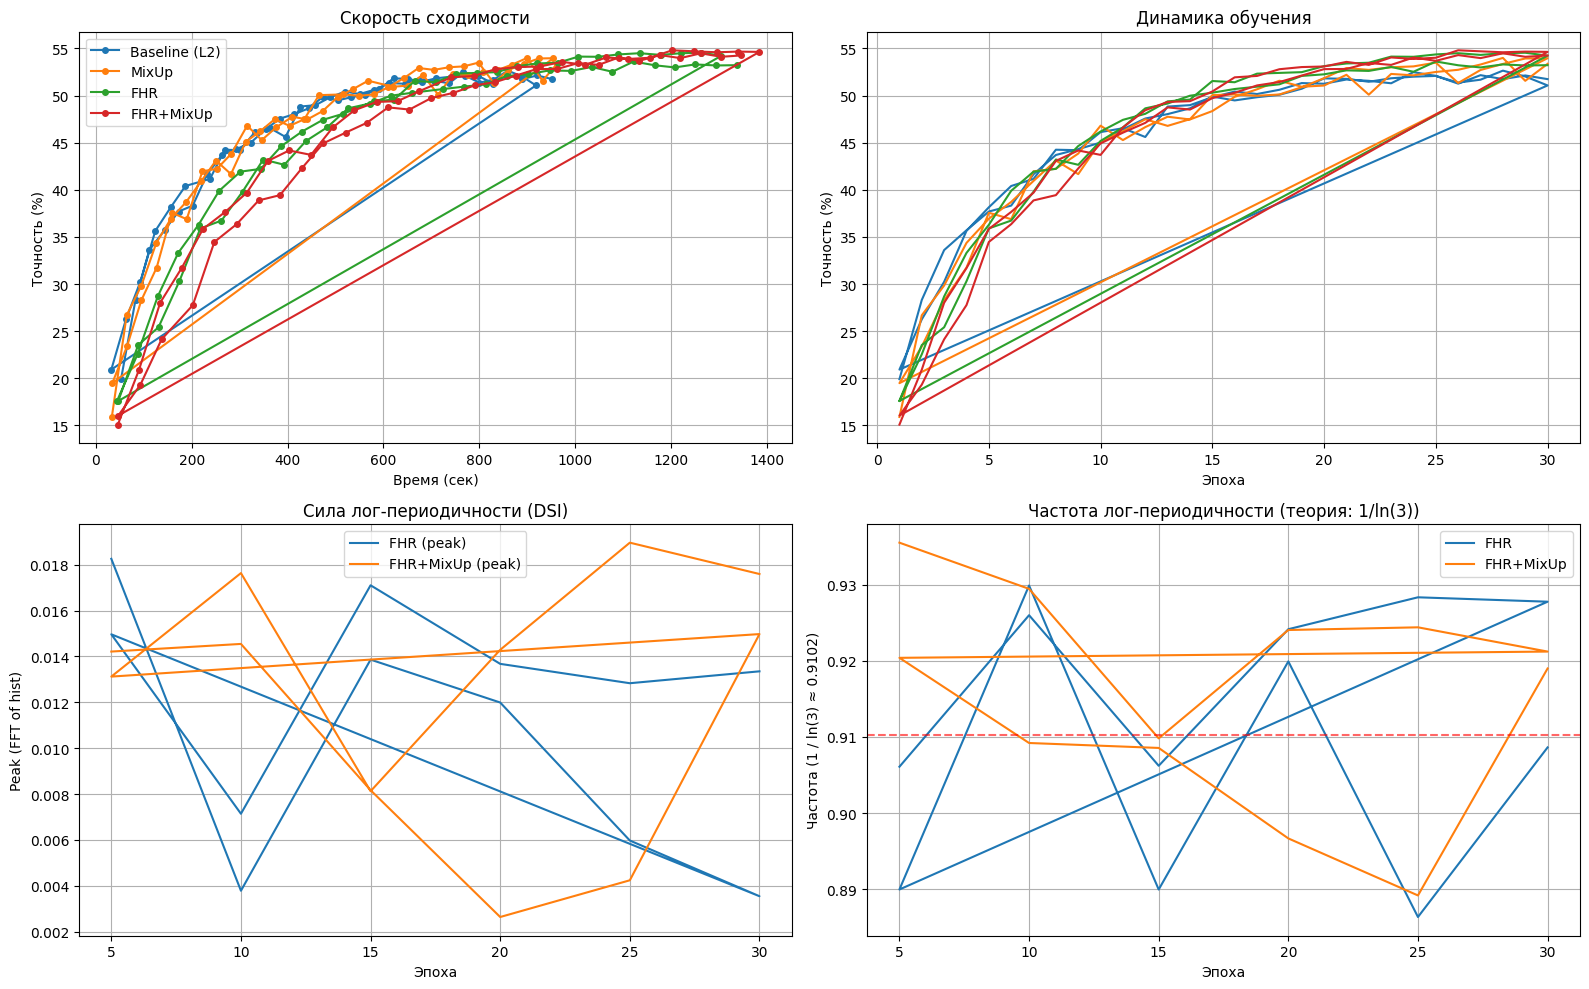


===== РАСШИРЕННЫЙ ОТЧЁТ =====
Baseline (L2)        | Acc: 51.90 ± 0.02 | Время: не достигнуто | Ускорение: -
MixUp                | Acc: 53.37 ± 0.39 | Время: не достигнуто | Ускорение: -
FHR                  | Acc: 53.84 ± 0.59 | Время: не достигнуто | Ускорение: -
FHR+MixUp            | Acc: 54.46 ± 0.17 | Время: не достигнуто | Ускорение: -

Сохранён анализ весов в weight_analysis.csv и изображения в weight_plots/
Результаты сохранены в: /content/fhr_results.csv
Анализ весов (если был) сохранён в: /content/weight_analysis.csv
Изображения распределений в: /content/weight_plots
Чекпоинты в: /content/checkpoints


In [1]:
# -*- coding: utf-8 -*-
"""
Ускоренный FHR vs Baseline — финальная версия (патчи безопасности + расширенный DSI анализ)

Добавлено/исправлено:
  • Безопасный tan (через sin/cos + clamp)
  • Корректный unstable_ratio (по элементам)
  • FFT анализа по гистограмме log(|w|) с Hann-окном
  • Подсчёт SNR и bootstrap p-value пика в окне ожидаемой частоты
  • По-слойный DSI-анализ (top-K слоёв), CSV + bar-график
  • Сохранение картинок в weight_plots/
  • Анализ редуцирован (подвыборка)
  • Проверка NaN/Inf в градиентах и безопасный fallback
  • Сохранение лучшей модели (checkpoints/)
  • Поправка подписи частоты: 1/ln    (3) ≈ 0.9102
"""

import os
import random
import math
import time
from typing import Dict, Tuple, Optional, List

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.auto import tqdm

# ========== 1) ускоренная среда ==========
def setup_accelerated_environment(seed=1337, deterministic=False) -> Tuple[torch.device, int]:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = deterministic
    torch.backends.cudnn.benchmark = not deterministic

    try:
        num_workers = max(1, len(os.sched_getaffinity(0)) * 2)
    except Exception:
        num_workers = 4

    print(f"Ускоренный режим: {device}, workers={num_workers}")
    return device, num_workers


DEVICE, NUM_WORKERS = setup_accelerated_environment()

# создаём папки для артефактов
os.makedirs("weight_plots", exist_ok=True)
os.makedirs("checkpoints", exist_ok=True)

# ========== 2) логгер ==========
class AcceleratedLogger:
    def __init__(self, csv_path="fhr_results.csv", update_freq=3):
        self.history = []
        self.csv_path = csv_path
        self.update_freq = update_freq
        # для анализа весов: список словарей с ключами run, epoch, peak_value, actual_freq, snr, pval, img_path
        self.weight_analysis = []
        if os.path.exists(csv_path):
            try:
                os.remove(csv_path)
            except Exception:
                pass

    def log(self, epoch, acc, loss, run_name, seed, time_elapsed, **hparams):
        rec = {
            "run": run_name,
            "seed": seed,
            "epoch": int(epoch),
            "accuracy": float(acc),
            "loss": float(loss),
            "time": float(time_elapsed),
        }
        rec.update(hparams)
        self.history.append(rec)

        if epoch % self.update_freq == 0:
            pd.DataFrame(self.history).to_csv(self.csv_path, index=False)
            self.plot()

    def log_weight_analysis(self, rec: Dict):
        """Добавляем запись в weight_analysis (не в main history)."""
        self.weight_analysis.append(rec)
        # периодически сохраняем
        if len(self.weight_analysis) % 5 == 0:
            pd.DataFrame(self.weight_analysis).to_csv("weight_analysis.csv", index=False)

    def plot(self):
        clear_output(wait=True)
        df = pd.DataFrame(self.history)
        plt.figure(figsize=(16, 10))

        if not df.empty:
            # точность по времени
            plt.subplot(221)
            for run in df["run"].unique():
                run_df = df[df["run"] == run]
                plt.plot(run_df["time"], run_df["accuracy"], label=run, marker='o', markersize=4)
            plt.xlabel("Время (сек)")
            plt.ylabel("Точность (%)")
            plt.title("Скорость сходимости")
            plt.legend()
            plt.grid(True)

            # точность по эпохам
            plt.subplot(222)
            for run in df["run"].unique():
                run_df = df[df["run"] == run]
                plt.plot(run_df["epoch"], run_df["accuracy"], label=run)
            plt.xlabel("Эпоха")
            plt.ylabel("Точность (%)")
            plt.title("Динамика обучения")
            plt.grid(True)

        # Визуализация анализа весов (если есть данные)
        if self.weight_analysis:
            wadf = pd.DataFrame(self.weight_analysis)
            # DSI сила (пик или SNR)
            plt.subplot(223)
            for run in wadf["run"].unique():
                run_df = wadf[wadf["run"] == run]
                plt.plot(run_df["epoch"], run_df["peak_value"], label=f"{run} (peak)")
            plt.xlabel("Эпоха")
            plt.ylabel("Peak (FFT of hist)")
            plt.title("Сила лог-периодичности (DSI)")
            plt.grid(True)
            plt.legend()

            # частота
            plt.subplot(224)
            for run in wadf["run"].unique():
                run_df = wadf[wadf["run"] == run]
                plt.plot(run_df["epoch"], run_df["actual_freq"], label=run)
            plt.axhline(y=1.0 / np.log(3.0), color='r', linestyle='--', alpha=0.6)
            plt.xlabel("Эпоха")
            plt.ylabel("Частота (1 / ln(3) ≈ 0.9102)")
            plt.title("Частота лог-периодичности (теория: 1/ln(3))")
            plt.grid(True)
            plt.legend()

        plt.tight_layout()
        plt.show()

    def final_report(self):
        df = pd.DataFrame(self.history)
        if df.empty:
            print("Нет данных для отчёта.")
            return

        target_acc = 55.0
        results = {}

        for run in df["run"].unique():
            run_df = df[df["run"] == run]
            final_accs = []
            times_to_target = []

            for seed in run_df["seed"].unique():
                seed_df = run_df[run_df["seed"] == seed]
                final_acc = seed_df.tail(3)["accuracy"].mean()
                final_accs.append(final_acc)

                reached = seed_df[seed_df["accuracy"] >= target_acc]
                if not reached.empty:
                    times_to_target.append(reached.iloc[0]["time"])

            results[run] = {
                "final_acc_mean": np.mean(final_accs),
                "final_acc_std": np.std(final_accs),
                "time_mean": np.mean(times_to_target) if times_to_target else None,
                "time_std": np.std(times_to_target) if len(times_to_target) > 1 else 0.0
            }

        baseline_time = results.get("Baseline (L2)", {}).get("time_mean", None)

        print("\n===== РАСШИРЕННЫЙ ОТЧЁТ =====")
        for run, data in results.items():
            acc_str = f"{data['final_acc_mean']:.2f} ± {data['final_acc_std']:.2f}"
            if data["time_mean"] is not None and baseline_time is not None:
                if run != "Baseline (L2)":
                    speedup = baseline_time / data["time_mean"] if data["time_mean"] > 0 else float('nan')
                    speedup_str = f"{speedup:.2f}x"
                else:
                    speedup_str = "-"
                time_str = f"{data['time_mean']:.1f} ± {data['time_std']:.1f} сек"
            else:
                speedup_str = "-"
                time_str = "не достигнуто"
            print(f"{run:20} | Acc: {acc_str} | Время: {time_str} | Ускорение: {speedup_str}")

        if self.weight_analysis:
            print("\nСохранён анализ весов в weight_analysis.csv и изображения в weight_plots/")

# единый логгер
LOGGER = AcceleratedLogger()

# ========== 3) даталоадеры (с опциональными аугментациями) ==========
class Cutout(object):
    """Простой Cutout как трансформ."""
    def __init__(self, size=8):
        self.size = size

    def __call__(self, img: torch.Tensor):
        c, h, w = img.shape
        sz = self.size
        y = np.random.randint(h)
        x = np.random.randint(w)
        y1 = np.clip(y - sz // 2, 0, h)
        y2 = np.clip(y + sz // 2, 0, h)
        x1 = np.clip(x - sz // 2, 0, w)
        x2 = np.clip(x + sz // 2, 0, w)
        img[:, y1:y2, x1:x2] = 0.0
        return img

def get_fast_dataloaders(batch_size=128, use_randaugment=False, use_cutout=False):
    mean = (0.5071, 0.4867, 0.4408)
    std = (0.2675, 0.2565, 0.2761)

    aug = []
    if use_randaugment:
        try:
            aug.append(T.RandAugment(num_ops=2, magnitude=9))
        except AttributeError:
            pass

    transform_train = T.Compose([
        T.RandomCrop(32, padding=4),
        T.RandomHorizontalFlip(),
        *aug,
        T.ToTensor(),
        T.Normalize(mean, std),
        *([Cutout(size=8)] if use_cutout else []),
    ])
    transform_test = T.Compose([
        T.ToTensor(),
        T.Normalize(mean, std)
    ])

    trainset = torchvision.datasets.CIFAR100("./data", train=True, download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR100("./data", train=False, download=True, transform=transform_test)

    persistent = NUM_WORKERS > 0
    train_loader = DataLoader(
        trainset, batch_size=batch_size, shuffle=True,
        num_workers=NUM_WORKERS, pin_memory=True,
        persistent_workers=persistent)
    test_loader = DataLoader(
        testset, batch_size=256, shuffle=False,
        num_workers=NUM_WORKERS, pin_memory=True)
    return train_loader, test_loader

def fast_mixup(x, y, alpha=0.2):
    if alpha <= 0.0:
        return x, y, y, 1.0
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    mixed_x = lam * x + (1.0 - lam) * x[idx]
    return mixed_x, y, y[idx], lam

# ========== 4) FHR (безопасный) ==========
class FHRRegularizer(nn.Module):
    def __init__(self, model: nn.Module, a: float = 3.0, percentile: int = 15,
                 kappa: float = 2.0, exclude_bn_bias: bool = True):
        super().__init__()
        assert a > 1.0
        self.a = float(a)
        self.log_a = math.log(self.a)
        self.percentile = int(percentile)
        self.kappa = float(kappa)
        self.exclude_bn_bias = bool(exclude_bn_bias)
        self.w0_by_param: Dict[str, float] = self._compute_w0_per_param(model)
        self.unstable_ratio = 0.0
        self.stability_history = []

    @torch.no_grad()
    def _compute_w0_per_param(self, model: nn.Module) -> Dict[str, float]:
        w0: Dict[str, float] = {}
        for name, p in model.named_parameters():
            if not p.requires_grad:
                continue
            if self.exclude_bn_bias and (name.endswith('.bias') or 'bn' in name.lower() or 'downsample.1' in name.lower()):
                continue
            if p.numel() == 0:
                continue
            q = torch.quantile(p.detach().abs().flatten(), self.percentile / 100.0)
            q = float(torch.clamp(q, min=1e-8).item())
            w0[name] = q
        return w0

    @torch.no_grad()
    def refresh_w0(self, model: nn.Module):
        self.w0_by_param = self._compute_w0_per_param(model)

    def forward(self, model: nn.Module) -> torch.Tensor:
        acc = None
        two_pi_over_log_a = (2.0 * math.pi) / self.log_a
        params_iter = list(model.parameters())
        if len(params_iter) == 0:
            return torch.tensor(0.0, device=DEVICE)

        device = params_iter[0].device
        param_count = 0
        unstable_elements = 0
        total_elements = 0

        for name, p in model.named_parameters():
            if not p.requires_grad:
                continue
            if self.exclude_bn_bias and (name.endswith('.bias') or 'bn' in name.lower() or 'downsample.1' in name.lower()):
                continue
            if p.numel() == 0:
                continue

            abs_w = p.abs()
            w0 = self.w0_by_param.get(name, 1e-3)
            log_vals = torch.log(abs_w / w0 + 1e-12)
            theta = two_pi_over_log_a * log_vals

            # безопасный tan: sin/cos с защитой от нуля
            sin_theta = torch.sin(theta)
            cos_theta = torch.cos(theta)
            safe_cos = torch.clamp(cos_theta, min=1e-6)
            stab = sin_theta / safe_cos

            # stability mask на уровне элементов
            stability_mask = (two_pi_over_log_a * stab.abs()) < 4.0
            unstable_elements += ((~stability_mask).float().sum().item())
            total_elements += stability_mask.numel()

            # мягкий гейт
            gate = torch.sigmoid(self.kappa * (4.0 - (two_pi_over_log_a * stab).abs()))

            term = (abs_w ** 4) * 0.5 * (1.0 - torch.cos(theta)) * gate
            layer_pen = term.mean()

            acc = layer_pen if acc is None else acc + layer_pen
            param_count += 1

        self.unstable_ratio = unstable_elements / max(1, total_elements)
        self.stability_history.append(self.unstable_ratio)

        # Автонастройка kappa
        if self.unstable_ratio > 0.3 and param_count > 0:
            self.kappa = max(1.0, self.kappa * 0.95)

        if acc is None or param_count == 0:
            return torch.zeros((), device=device)

        return acc / float(param_count)

# ========== 5) оценка ==========
@torch.no_grad()
def evaluate_model(model, loader):
    model.eval()
    correct, total = 0, 0
    for x, y in loader:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)
        with torch.cuda.amp.autocast():
            logits = model(x)
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return 100.0 * correct / max(1, total)

# ========== 6) утилиты анализа DSI ==========
def _fft_peak_stats_from_hist(hist: np.ndarray, bin_width: float, expected_freq: float,
                              n_boot: int = 400) -> Dict[str, float]:
    """
    Возвращает peak, snr, pval и actual_freq.
    Используется rFFT от центрированной гистограммы с Hann-окном.
    """
    h = hist - hist.mean()
    window = np.hanning(len(h))
    h_win = h * window
    fft_vals = np.abs(np.fft.rfft(h_win))
    freqs = np.fft.rfftfreq(len(h), d=bin_width)

    idx = int(np.argmin(np.abs(freqs - expected_freq)))
    peak = float(fft_vals[idx])
    snr = peak / (np.median(fft_vals) + 1e-12)

    # bootstrap/permutation нулевой модели
    sims = []
    for _ in range(max(1, n_boot)):
        perm = np.random.permutation(h)
        sim_fft = np.abs(np.fft.rfft(perm * window))
        sims.append(sim_fft[idx])
    sims = np.array(sims)
    pval = float((np.sum(sims >= peak) + 1) / (len(sims) + 1))

    return {"peak": peak, "snr": snr, "pval": pval, "actual_freq": float(freqs[idx])}

def analyze_weight_distribution_fft_hist(model, epoch, run_name,
                                         nbins=256, n_boot=400,
                                         img_suffix="global") -> Dict:
    """
    Анализ DSI: гистограмма log(|w|) -> rFFT -> peak/SNR/p-value.
    Сохраняет изображение гистограммы с маркерами в weight_plots/.
    """
    all_weights: List[np.ndarray] = []
    for p in model.parameters():
        if p.requires_grad:
            a = p.detach().abs().cpu().numpy().flatten()
            if a.size:
                # подвыборка больших массивов
                if a.size > 200000:
                    a = np.random.choice(a, size=200000, replace=False)
                all_weights.append(a)
    if not all_weights:
        return {}

    lw = np.log(np.concatenate(all_weights) + 1e-12)
    hist, edges = np.histogram(lw, bins=nbins, density=True)
    bin_width = edges[1] - edges[0]

    expected_freq = 1.0 / np.log(3.0)  # период ln(3)
    stats = _fft_peak_stats_from_hist(hist, bin_width, expected_freq, n_boot=n_boot)

    # Сохраняем гистограмму как файл
    centers = (edges[:-1] + edges[1:]) / 2.0
    plt.figure(figsize=(8, 5))
    plt.plot(centers, hist, label='hist(log|w|)')
    w0 = np.mean(lw)
    for k in range(-5, 6):
        peak_x = w0 + k * np.log(3.0)
        if centers.min() <= peak_x <= centers.max():
            plt.axvline(peak_x, color='r', linestyle='--', alpha=0.3)
    plt.title(f"hist(log|w|) — {run_name} epoch={epoch} [{img_suffix}]")
    plt.xlabel("log(|w|)")
    plt.ylabel("density")
    plt.grid(True)
    fname = f"weight_plots/{run_name.replace(' ', '_')}_epoch{epoch}_{img_suffix}.png"
    plt.tight_layout()
    plt.savefig(fname)
    plt.close()

    return {
        "run": run_name,
        "epoch": int(epoch),
        "dsi_peak": float(stats["peak"]),
        "expected_freq": float(expected_freq),
        "actual_freq": float(stats["actual_freq"]),
        "peak_value": float(stats["peak"]),
        "snr": float(stats["snr"]),
        "pval": float(stats["pval"]),
        "img_path": fname
    }

def analyze_layers_dsi(model, epoch, run_name,
                       nbins=192, n_boot=200, topk=8) -> Optional[str]:
    """
    По-слойный DSI-анализ.
    Возвращает путь к bar-графику top-K слоёв по SNR (и сохраняет CSV).
    """
    expected_freq = 1.0 / np.log(3.0)
    rows = []
    for name, p in model.named_parameters():
        if (not p.requires_grad) or p.numel() == 0:
            continue
        # игнорируем bias и BN/shortcut по умолчанию — можно при желании убрать
        lname = name.lower()
        if any(x in lname for x in ['.bias', 'bn', 'downsample.1']):
            continue

        w = p.detach().abs().cpu().numpy().flatten()
        if w.size == 0:
            continue
        # подвыборка
        if w.size > 150000:
            w = np.random.choice(w, size=150000, replace=False)
        lw = np.log(w + 1e-12)

        hist, edges = np.histogram(lw, bins=nbins, density=True)
        bin_width = edges[1] - edges[0]
        stats = _fft_peak_stats_from_hist(hist, bin_width, expected_freq, n_boot=n_boot)
        rows.append({
            "layer": name,
            "peak": float(stats["peak"]),
            "snr": float(stats["snr"]),
            "pval": float(stats["pval"]),
            "actual_freq": float(stats["actual_freq"]),
        })

    if not rows:
        return None

    df = pd.DataFrame(rows).sort_values(["snr", "peak"], ascending=False)
    csv_path = f"weight_plots/{run_name.replace(' ', '_')}_epoch{epoch}_layer_dsi.csv"
    df.to_csv(csv_path, index=False)

    # bar-плот top-K
    top = df.head(topk)
    plt.figure(figsize=(10, 5))
    plt.barh(top["layer"][::-1], top["snr"][::-1])
    plt.xlabel("SNR (peak / median FFT)")
    plt.title(f"Top-{topk} слоёв по SNR — {run_name} epoch={epoch}")
    plt.tight_layout()
    fig_path = f"weight_plots/{run_name.replace(' ', '_')}_epoch{epoch}_layer_top{topk}.png"
    plt.savefig(fig_path)
    plt.close()
    return fig_path

# глобально текущее описание эксперимента (чтобы не менять сигнатуры)
_CURRENT_EXP = {}

# ========== 7) обучение ==========
def build_optimizer_and_scheduler(model, epochs, exp):
    opt_name = exp.get("opt", "adamw").lower()
    lr = float(exp.get("lr", 0.001 if opt_name == "adamw" else 0.1))
    weight_decay = float(exp.get("weight_decay", 0.01))
    warmup_epochs = int(exp.get("warmup_epochs", 3 if opt_name == "sgd" else 0))

    if opt_name == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay, nesterov=True)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    else:
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = None

    return optimizer, scheduler, warmup_epochs

def maybe_warmup(optimizer, base_lr, epoch, warmup_epochs):
    if warmup_epochs > 0 and epoch <= warmup_epochs:
        scale = float(epoch) / float(max(1, warmup_epochs))
        for pg in optimizer.param_groups:
            pg["lr"] = base_lr * scale

def train_experiment(run_name, use_fhr=False, use_mixup=False, epochs=30, seed=42, **exp_overrides):
    setup_accelerated_environment(seed)
    start_time = time.time()

    exp = {**_CURRENT_EXP, **exp_overrides} if isinstance(_CURRENT_EXP, dict) else exp_overrides
    batch_size = int(exp.get("batch_size", 128))
    use_ra = bool(exp.get("use_randaugment", False))
    use_cutout = bool(exp.get("use_cutout", False))
    mix_alpha = float(exp.get("mix_alpha", 0.2))
    grad_clip = float(exp.get("grad_clip", 1.0))
    fhr_refresh_every = int(exp.get("fhr_refresh_every", 5))
    fhr_ramp_epochs = int(exp.get("fhr_ramp_epochs", 5))
    early_stop_patience = int(exp.get("early_stop_patience", 8))
    analyze_every = int(exp.get("analyze_every", 5))  # анализ DSI каждые N эпох
    nbins = int(exp.get("nbins", 256))
    n_boot = int(exp.get("n_boot", 400))
    layer_analysis = bool(exp.get("layer_analysis", True))
    layer_topk = int(exp.get("layer_topk", 8))

    train_loader, test_loader = get_fast_dataloaders(batch_size=batch_size, use_randaugment=use_ra, use_cutout=use_cutout)
    model = torchvision.models.resnet18(num_classes=100).to(DEVICE)

    optimizer, scheduler, warmup_epochs = build_optimizer_and_scheduler(model, epochs, exp)
    base_lr = optimizer.param_groups[0]["lr"]

    criterion = nn.CrossEntropyLoss(label_smoothing=float(exp.get("label_smoothing", 0.0)))

    if use_fhr:
        fhr = FHRRegularizer(
            model,
            a=float(exp.get("a", 3.0)),
            percentile=int(exp.get("percentile", 15)),
            kappa=float(exp.get("kappa", 2.0)),
            exclude_bn_bias=bool(exp.get("exclude_bn_bias", True)),
        )
        fhr_weight = float(exp.get("fhr_weight", 0.05))
    else:
        fhr, fhr_weight = None, 0.0

    scaler = torch.cuda.amp.GradScaler()

    # early stopping & checkpoint
    best_acc = 0.0
    patience_counter = 0
    stopped_early = False

    for epoch in range(1, epochs + 1):
        model.train()
        maybe_warmup(optimizer, base_lr, epoch, warmup_epochs)

        total_loss = 0.0
        progress = tqdm(train_loader, desc=f"{run_name} Epoch {epoch}/{epochs}")

        curr_fhr_weight = fhr_weight * min(1.0, float(epoch) / max(1.0, fhr_ramp_epochs))

        for x, y in progress:
            x = x.to(DEVICE, non_blocking=True)
            y = y.to(DEVICE, non_blocking=True)

            if use_mixup:
                x, ya, yb, lam = fast_mixup(x, y, alpha=mix_alpha)
            else:
                ya, yb, lam = y, y, 1.0

            with torch.cuda.amp.autocast():
                logits = model(x)
                loss_ce = lam * criterion(logits, ya) + (1.0 - lam) * criterion(logits, yb)
                loss = loss_ce + (curr_fhr_weight * fhr(model) if fhr is not None else 0.0)

            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()

            # unscale -> clip -> NaN/Inf check
            scaler.unscale_(optimizer)
            if grad_clip is not None and grad_clip > 0.0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip)

            nan_inf = False
            for p in model.parameters():
                if p.grad is not None:
                    g = p.grad
                    if torch.isnan(g).any() or torch.isinf(g).any():
                        nan_inf = True
                        break

            if nan_inf:
                print(f"[WARNING] NaN/Inf grads at epoch {epoch}. Skipping step.")
                if fhr is not None:
                    old_kappa = fhr.kappa
                    fhr.kappa = max(1.0, fhr.kappa * 0.9)
                    print(f"  reduced fhr.kappa: {old_kappa:.3f} -> {fhr.kappa:.3f}")
                optimizer.zero_grad()
                try:
                    scaler.update()
                except Exception:
                    pass
                continue

            scaler.step(optimizer)
            scaler.update()

            total_loss += float(loss.item())
            progress.set_postfix({"loss": float(loss.item())})

        if scheduler is not None:
            scheduler.step()

        # периодически обновляем w0 для FHR
        if fhr is not None and (epoch % max(1, fhr_refresh_every) == 0):
            fhr.refresh_w0(model)

        acc = evaluate_model(model, test_loader)
        total_time = time.time() - start_time

        # Анализ распределения весов для проверки DSI (редко)
        if fhr is not None and (epoch % analyze_every == 0 or epoch == epochs):
            res = analyze_weight_distribution_fft_hist(
                model, epoch, run_name, nbins=nbins, n_boot=n_boot, img_suffix="global"
            )
            if res:
                LOGGER.log_weight_analysis(res)

            if layer_analysis:
                try:
                    layer_fig = analyze_layers_dsi(
                        model, epoch, run_name, nbins=max(64, nbins//2), n_boot=max(50, n_boot//4), topk=layer_topk
                    )
                    if layer_fig:
                        # фиктивная запись, чтобы видеть файл в weight_analysis.csv (не влияет на кривые)
                        LOGGER.log_weight_analysis({
                            "run": run_name, "epoch": int(epoch),
                            "peak_value": res.get("peak_value", np.nan) if res else np.nan,
                            "actual_freq": res.get("actual_freq", np.nan) if res else np.nan,
                            "snr": res.get("snr", np.nan) if res else np.nan,
                            "pval": res.get("pval", np.nan) if res else np.nan,
                            "img_path": layer_fig, "note": "layer_topk_plot"
                        })
                except Exception as e:
                    print("Layer DSI analysis failed:", e)

        # чекпоинтинг best model
        if acc > best_acc:
            best_acc = acc
            patience_counter = 0
            chk_name = f"checkpoints/{run_name.replace(' ', '_')}_seed{seed}_best.pth"
            try:
                torch.save({
                    "model_state": model.state_dict(),
                    "optimizer_state": optimizer.state_dict(),
                    "epoch": epoch,
                    "acc": acc
                }, chk_name)
            except Exception as e:
                print("Warning: cannot save checkpoint:", e)
        else:
            patience_counter += 1

        # логируем ключевые гиперпараметры
        LOGGER.log(
            epoch, acc, total_loss / max(1, len(train_loader)),
            run_name, seed, total_time,
            lr=optimizer.param_groups[0]["lr"],
            fhr_weight=curr_fhr_weight,
            kappa=(getattr(fhr, "kappa", None) if fhr is not None else None),
            unstable_ratio=(getattr(fhr, "unstable_ratio", None) if fhr is not None else None),
            percentile=(getattr(fhr, "percentile", None) if fhr is not None else None),
            opt=type(optimizer).__name__,
            mix_alpha=(mix_alpha if use_mixup else 0.0),
            aug_ra=use_ra, aug_cutout=use_cutout,
        )

        # Early stopping
        if patience_counter >= early_stop_patience and epoch > 15:
            print(f"Early stopping на эпохе {epoch}")
            stopped_early = True
            break

        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    if stopped_early:
        print(f"Обучение остановлено досрочно на эпохе {epoch} с точностью {best_acc:.2f}%")

    return model

# ========== 8) запуск ==========
EXPERIMENTS = [
    {"name": "Baseline (L2)", "use_fhr": False, "use_mixup": False,
     "opt": "adamw", "lr": 0.001, "weight_decay": 0.01,
     "grad_clip": 1.0},

    {"name": "MixUp", "use_fhr": False, "use_mixup": True,
     "opt": "adamw", "lr": 0.001, "weight_decay": 0.01,
     "mix_alpha": 0.2, "grad_clip": 1.0},

    {"name": "FHR", "use_fhr": True, "use_mixup": False,
     "opt": "sgd", "lr": 0.1, "weight_decay": 0.0,
     "fhr_weight": 0.05, "a": 3.0, "percentile": 15, "kappa": 2.0,
     "fhr_ramp_epochs": 5, "fhr_refresh_every": 5, "grad_clip": 1.0,
     "warmup_epochs": 3, "label_smoothing": 0.0,
     "use_randaugment": False, "use_cutout": False,
     "analyze_every": 5, "nbins": 256, "n_boot": 400,
     "layer_analysis": True, "layer_topk": 8},

    {"name": "FHR+MixUp", "use_fhr": True, "use_mixup": True,
     "opt": "sgd", "lr": 0.1, "weight_decay": 0.0,
     "fhr_weight": 0.05, "a": 3.0, "percentile": 15, "kappa": 2.0,
     "fhr_ramp_epochs": 5, "fhr_refresh_every": 5, "grad_clip": 1.0,
     "warmup_epochs": 3, "mix_alpha": 0.2, "label_smoothing": 0.0,
     "use_randaugment": False, "use_cutout": False,
     "analyze_every": 5, "nbins": 256, "n_boot": 400,
     "layer_analysis": True, "layer_topk": 8},
]

SEEDS = [1337, 2023]

print("===== ЗАПУСК ЭКСПЕРИМЕНТОВ =====")
for exp in EXPERIMENTS:
    for seed in SEEDS:
        print(f"Запуск: {exp['name']} (seed={seed})")
        _CURRENT_EXP = exp
        train_experiment(
            run_name=exp["name"],
            use_fhr=exp["use_fhr"],
            use_mixup=exp["use_mixup"],
            epochs=int(exp.get("epochs", 30)),
            seed=seed
        )

LOGGER.final_report()
print("Результаты сохранены в:", os.path.abspath("fhr_results.csv"))
print("Анализ весов (если был) сохранён в:", os.path.abspath("weight_analysis.csv"))
print("Изображения распределений в:", os.path.abspath("weight_plots/"))
print("Чекпоинты в:", os.path.abspath("checkpoints/"))
